## Introduction

This project aims to develop a machine learning model for predicting sepsis in patients based on various clinical features. Sepsis is a life-threatening condition that arises when the body's response to an infection causes inflammation throughout the body. Early detection and timely intervention are critical for improving patient outcomes in sepsis cases.

## Objectives

1.Develop a predictive model to identify patients at risk of developing sepsis.

2.Utilize machine learning techniques to analyze clinical data and extract patterns indicative of sepsis.

3.Provide healthcare professionals with a tool for early detection and intervention in sepsis cases.

## Business Understanding

**Problem Statement**

Sepsis is a leading cause of morbidity and mortality worldwide, with delayed recognition and treatment contributing to poor patient outcomes. The lack of efficient tools for early sepsis detection in clinical settings poses a significant challenge for healthcare providers.


**Stakeholders**

-Healthcare Professionals: Physicians, nurses, and other medical staff responsible for patient care.

-Patients: Individuals at risk of developing sepsis or already diagnosed with sepsis.

-Hospital Administrators: Decision-makers responsible for implementing new technologies and protocols for patient management.

**Value Proposition**
The development of an accurate and efficient sepsis prediction model offers the following benefits:

Early Detection: Prompt identification of patients at risk of sepsis allows for timely intervention and improved outcomes.
Resource Optimization: Allocation of medical resources and interventions to high-risk patients, optimizing healthcare delivery.
Cost Reduction: Preventing sepsis-related complications and reducing the financial burden on healthcare systems.

**Research Questions**

1.What is the distribution of Sepsis

2.What is the distribution of Age

3.How Many Patients have Insurance

4.Is Blood Pressure Affected by Age

5.How many patients in each BMI category have sepsis?


## Hypothesis

Null Hypothesis (H0): There is no significant relationship between a patient's age and the likelihood of developing sepsis.

Alternative Hypothesis (H1): The age of a patient is a significant factor that influences the likelihood of developing sepsis.

In [6]:
## Importations
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statistics as stat
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import *
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import pickle

In [7]:
# load train and test data
train_df = pd.read_csv('datasets\Paitients_Files_Train.csv')
test_df = pd.read_csv('datasets\Paitients_Files_Test.csv')

**Data Understanding**

-ID: number to represent patient ID

-PRG: Plasma glucose

-PL: Blood Work Result-1 (mu U/ml)

-PR: Blood Pressure (mmHg)

-SK: Blood Work Result-2(mm)

-TS: Blood Work Result-3 (muU/ml)

-M11: Body mass index (weight in kg/(height in m)^2

-BD2: Blood Work Result-4 (mu U/ml)

-Age: patients age(years)

-Insurance: If a patient holds a valid insurance card

-Sepsis: Positive: if a patient in ICU will develop a sepsis , and Negative: otherwis otherwise

In [9]:
#checking the number of rows an columns for both the train and data set
train_df.shape,test_df.shape

((599, 11), (169, 10))

In [10]:
#first five rows of the train data
train_df.head()

,ID,PRG,PL,PR,SK,TS,M11,BD2,Age,Insurance,Sepssis
0,ICU200010,6,148,72,35,0,33.6,0.627,50,0,Positive
1,ICU200011,1,85,66,29,0,26.6,0.351,31,0,Negative
2,ICU200012,8,183,64,0,0,23.3,0.672,32,1,Positive
3,ICU200013,1,89,66,23,94,28.1,0.167,21,1,Negative
4,ICU200014,0,137,40,35,168,43.1,2.288,33,1,Positive


In [12]:
#first five rows of test data
test_df.head()

,ID,PRG,PL,PR,SK,TS,M11,BD2,Age,Insurance
0,ICU200609,1,109,38,18,120,23.1,0.407,26,1
1,ICU200610,1,108,88,19,0,27.1,0.400,24,1
2,ICU200611,6,96,0,0,0,23.7,0.190,28,1
3,ICU200612,1,124,74,36,0,27.8,0.100,30,1
4,ICU200613,7,150,78,29,126,35.2,0.692,54,0


In [13]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 599 entries, 0 to 598
Data columns (total 11 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   ID         599 non-null    object 
 1   PRG        599 non-null    int64  
 2   PL         599 non-null    int64  
 3   PR         599 non-null    int64  
 4   SK         599 non-null    int64  
 5   TS         599 non-null    int64  
 6   M11        599 non-null    float64
 7   BD2        599 non-null    float64
 8   Age        599 non-null    int64  
 9   Insurance  599 non-null    int64  
 10  Sepssis    599 non-null    object 
dtypes: float64(2), int64(7), object(2)
memory usage: 51.6+ KB


No missing values but Sepsis is wrongly mispelled as Sepssis.

In [15]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 169 entries, 0 to 168
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   ID         169 non-null    object 
 1   PRG        169 non-null    int64  
 2   PL         169 non-null    int64  
 3   PR         169 non-null    int64  
 4   SK         169 non-null    int64  
 5   TS         169 non-null    int64  
 6   M11        169 non-null    float64
 7   BD2        169 non-null    float64
 8   Age        169 non-null    int64  
 9   Insurance  169 non-null    int64  
dtypes: float64(2), int64(7), object(1)
memory usage: 13.3+ KB


The sepsis column is missing unlike in the train dataset

In [16]:
# Descriptive statistics of the train dataset
train_df.describe().T

,count,mean,std,min,25%,50%,75%,max
PRG,599.0,3.824708,3.362839,0.000,1.000,3.000,6.000,17.00
PL,599.0,120.153589,32.682364,0.000,99.000,116.000,140.000,198.00
PR,599.0,68.732888,19.335675,0.000,64.000,70.000,80.000,122.00
SK,599.0,20.562604,16.017622,0.000,0.000,23.000,32.000,99.00
TS,599.0,79.460768,116.576176,0.000,0.000,36.000,123.500,846.00
M11,599.0,31.920033,8.008227,0.000,27.100,32.000,36.550,67.10
BD2,599.0,0.481187,0.337552,0.078,0.248,0.383,0.647,2.42
Age,599.0,33.290484,11.828446,21.000,24.000,29.000,40.000,81.00
Insurance,599.0,0.686144,0.464447,0.000,0.000,1.000,1.000,1.00


In [17]:
# Categories in the Sepssis column
train_df['Sepssis'].value_counts()

Sepssis
Negative    391
Positive    208
Name: count, dtype: int64

## Exploratory Data Analysis

1. What the distribution of sepsis?

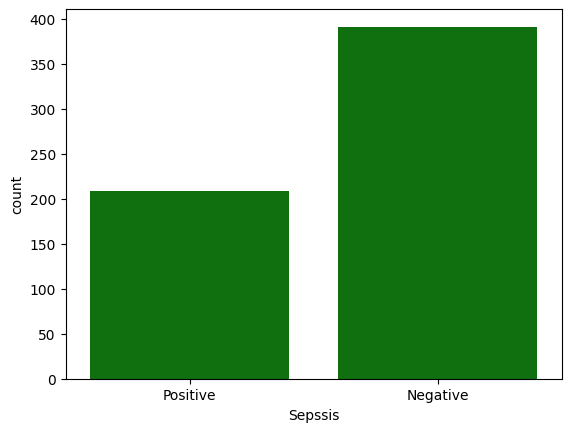

In [19]:
# Distribution of Sepssis
sns.countplot(x='Sepssis',data=train_df,color='green')
plt.show()

There are 391 negative cases which are the patients who did not develop sepsis during their stay in the intensive Care Unit(ICU). The positive cases are 208, which are the patients who developed sepsis during their stay in the ICU.

## 2. What is the distribution of ages for patients captured in the data?

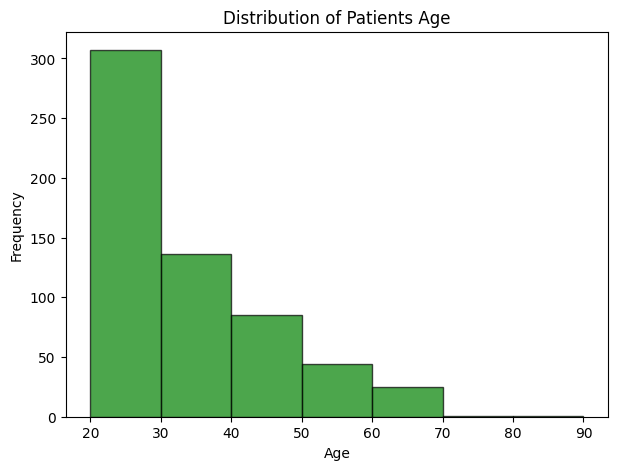

Mean Age: 33.29
Median Age: 29.0
Minimum Age: 21
Maximum Age: 81


In [21]:
# We plot the distribution of ages for all the patients
plt.figure(figsize=(7,5))
plt.hist(train_df['Age'],bins=7,range = (20,90),edgecolor='k',alpha=0.7,color='green')
plt.title("Distribution of Patients Age")
plt.xlabel("Age")
plt.ylabel("Frequency")
plt.show()

# Calculating the summary statistics of the age column
mean_age = train_df['Age'].mean()
median_age = train_df['Age'].median()
min_age = train_df['Age'].min()
max_age = train_df['Age'].max()

# Print summary statistics
print(f"Mean Age: {mean_age:.2f}")
print(f"Median Age: {median_age}")
print(f"Minimum Age: {min_age}")
print(f"Maximum Age: {max_age}")

## 3. How many patients have insurance?

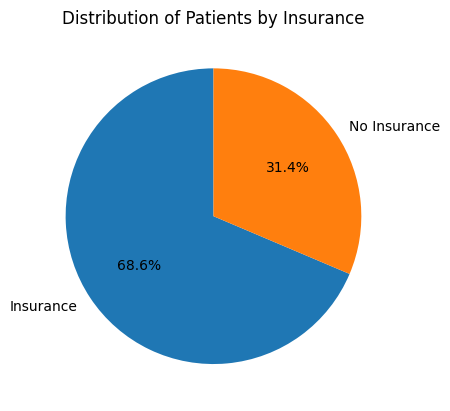

In [22]:
#We count the number of patients with insurance
insurance_count = train_df['Insurance'].value_counts()
labels = ['Insurance','No Insurance']
plt.title('Distribution of Patients by Insurance')
# We plot the pie chart
plt.pie(insurance_count,labels=labels,autopct='%1.1f%%', startangle=90)
plt.show()

## 4. Is Blood Pressure affected by Age?

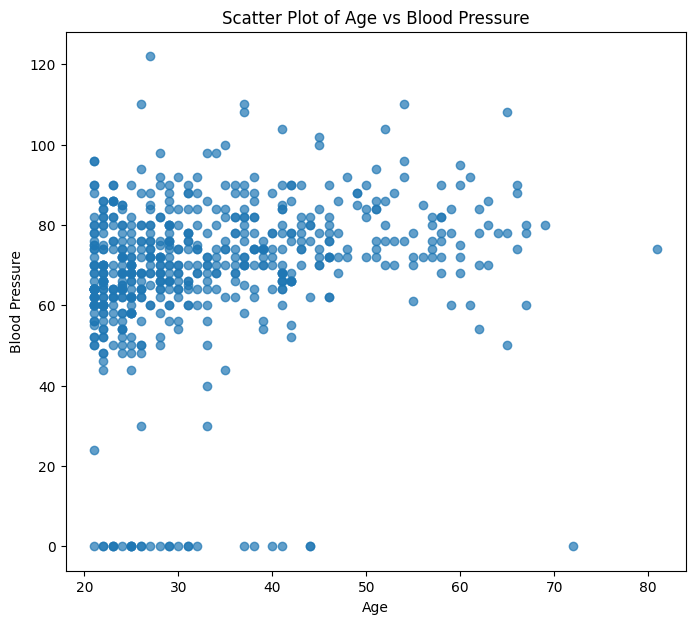

In [23]:
plt.figure(figsize=(8,7))
plt.scatter(train_df['Age'],train_df['PR'],alpha=0.7)
plt.xlabel('Age')
plt.ylabel('Blood Pressure')
plt.title("Scatter Plot of Age vs Blood Pressure")
plt.show()

Most of the Values lie between 40 and 80. This represents the systolic or diastolic blood pressure values. Most of the values cluster within this range which indicates that blood pressure tends to be within a relatively normal or typical range for a large portion of the population in the dataset.

## Hypothesis Testing

In [24]:
# We define Negative and Positive Sepsis Cases
Sepsis_Negative = train_df[train_df['Sepssis']=='Negative']
Sepsis_Positive = train_df[train_df['Sepssis']=='Positive']

In [25]:
t,p = stats.ttest_ind(Sepsis_Negative['Age'],Sepsis_Positive['Age'],equal_var=False)

In [26]:
print(p)

1.0859592786305662e-07


In [27]:
# Separate data into two groups: patients with sepsis (Sepsis: Positive) and without sepsis (Sepsis: Negative)
sepsis_positive = train_df[train_df['Sepssis'] == 'Positive']['Age']
sepsis_negative = train_df[train_df['Sepssis'] == 'Negative']['Age']

In [28]:
# Set significance level (alpha)
alpha = 0.05

 # Perform a two-sample independent t-test
t_stat, p_value = stats.ttest_ind(sepsis_positive, sepsis_negative, equal_var=False)

In [29]:
# Print the t-statistic and p-value
print(f"T-statistic: {t_stat}")
print(f"P-value: {p_value}")

T-statistic: 5.398028835705048
P-value: 1.0859592786305662e-07


In [30]:
# Compare p-value to alpha to make a decision
if p_value < alpha:
    print("Reject the null hypothesis. There is a significant difference in age between patients with and without sepsis.")
else:
    print("Fail to reject the null hypothesis. There is no significant difference in age between patients with and without sepsis.")

Reject the null hypothesis. There is a significant difference in age between patients with and without sepsis.


<Axes: xlabel='Age', ylabel='Count'>

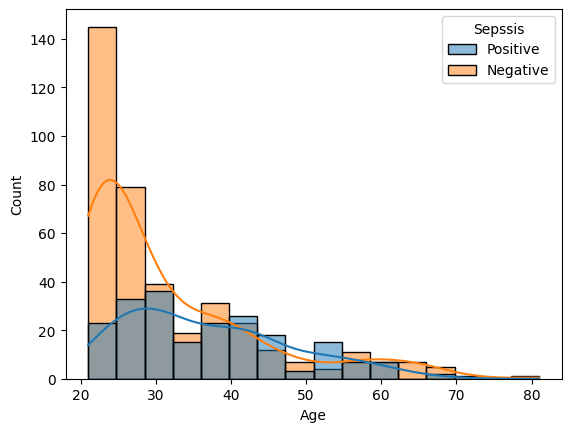

In [32]:
sns.histplot(data=train_df,x='Age',hue='Sepssis',kde=True)